## 1. Setup 

In [6]:
# !pip install pandas scikit-learn matplotlib joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from joblib import dump, load
import re
import os
import random

SEED = 42
random.seed(SEED); np.random.seed(SEED)
pd.set_option('display.max_colwidth', 200)


In [14]:
# Find the current path
import os
# get current directory
current_dir = os.getcwd()
# get parent directory
parent_dir = os.path.dirname(current_dir)
data_dir = parent_dir+r'\data'
contents = os.listdir(data_dir)
print (contents)

['all-data.csv', 'License.txt', 'README.txt', 'Sentences_50Agree.txt', 'Sentences_66Agree.txt', 'Sentences_75Agree.txt', 'Sentences_AllAgree.txt']


### 1. Read the data


In [38]:
import chardet
filepath = r"D:\MyGithubSource\kr-data-projects\financial-phrases-sentiment-analysis\data\all-data.csv"

# Read a small chunk of the file to guess encoding
with open(filepath, 'rb') as f:
    result = chardet.detect(f.read(10000))  # Read first 10KB
    print(result['encoding'])

# Use detected encoding to load the CSV
df = pd.read_csv(filepath, encoding=result['encoding'])
df.columns = ["Sentiment", "News Headline"]
df = df.rename(columns={"News Headline": "text", "Sentiment": "label"})
print(df.count())
df = df[["text", "label"]].dropna().drop_duplicates().reset_index(drop=True)
print (df.count())

ISO-8859-1
label    4845
text     4845
dtype: int64
text     4839
label    4839
dtype: int64


In [39]:
 # DO a quick sanity check

print(df.shape)
print(df.label.value_counts())
df.sample(5, random_state=SEED)


(4839, 2)
label
neutral     2872
positive    1363
negative     604
Name: count, dtype: int64


,text,label
3199,"The company serves customers in various industries , including process and resources , industrial machinery , architecture , building , construction , electrical , transportation , electronics , c...",neutral
2527,"On Dec. 1 , Grimaldi acquired 1.5 million shares and a 50.1-percent stake in Finnlines .",neutral
4100,The extracted filtrates are very high in clarity while the dried filter cakes meet required transport moisture limits (TMLs)for their ore grades .,neutral
1926,The use case dramatically narrows if you go only with the hot s Ltd.,neutral
1536,"In Penttil+Æ 's vision , the most important reason for the transaction is Russia .",neutral


## 2) Now do the EDA

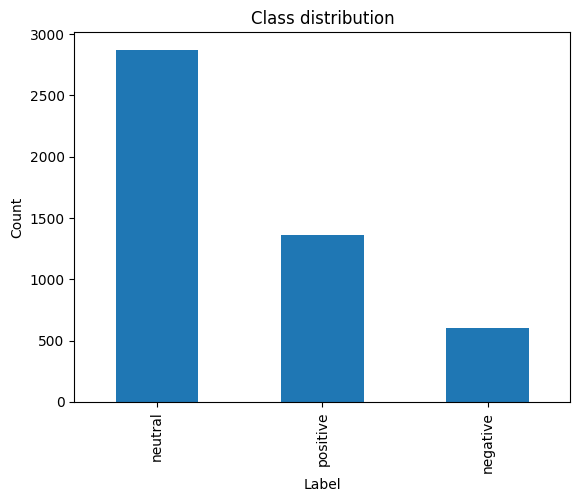

In [40]:
df.label.value_counts().plot(kind="bar")
plt.title("Class distribution"); plt.xlabel("Label"); plt.ylabel("Count"); plt.show()


### Text length distribution:

count    4839.000000
mean       23.092581
std         9.941816
min         2.000000
25%        16.000000
50%        21.000000
75%        29.000000
max        81.000000
Name: len, dtype: float64


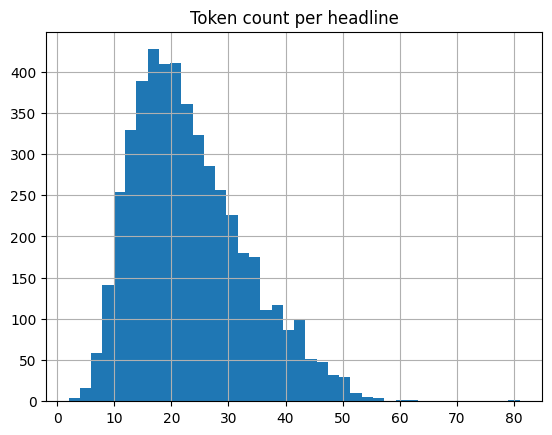

In [43]:


df["len"] = df.text.str.split().str.len()
print (df.len.describe())
df.len.hist(bins=40); plt.title("Token count per headline"); plt.show()


### Duplicates / weird rows:

In [44]:
dups = df.duplicated(subset=["text"]).sum()
print ("Duplicates: ", dups)
df[df.text.str.strip().eq("")].shape

Duplicates:  2


(0, 3)

### What to look for:

Severe class imbalance? (e.g., many neutrals). We’ll use macro-F1 and a robust classifier (LinearSVC) to handle that.

Very short texts? Headlines often are short; char n-grams can help later.

## 3) Minimal, finance-friendly text cleaning (one cell)

Keep case and numbers—tickers and amounts can carry signal. We’ll only normalize whitespace.

In [45]:
def basic_clean(s: str) -> str:
    s = s.strip()
    s = re.sub(r"\s+", " ", s)
    return s

df["text"] = df.text.astype(str).map(basic_clean)
df = df[df.text.str.len() > 0].reset_index(drop=True)


## 4) Train/validation split (one cell)

In [46]:
X_train, X_test, y_train, y_test = train_test_split(
    df["text"], df["label"], test_size=0.2, random_state=SEED, stratify=df["label"]
)
len(X_train), len(X_test), y_train.value_counts(normalize=True), y_test.value_counts(normalize=True)


(3871,
 968,
 label
 neutral     0.593645
 positive    0.281581
 negative    0.124774
 Name: proportion, dtype: float64,
 label
 neutral     0.592975
 positive    0.282025
 negative    0.125000
 Name: proportion, dtype: float64)

## 5) Baseline models (TF-IDF → LinearSVC / Logistic Regression)

### 5a) Quick baseline (one cell)

              precision    recall  f1-score   support

    negative      0.753     0.603     0.670       121
     neutral      0.780     0.883     0.828       574
    positive      0.706     0.571     0.632       273

    accuracy                          0.760       968
   macro avg      0.746     0.686     0.710       968
weighted avg      0.756     0.760     0.753       968



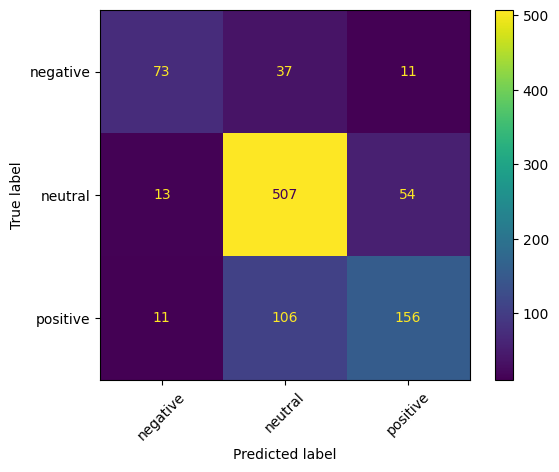

In [47]:
baseline = Pipeline([
    ("tfidf", TfidfVectorizer(
        ngram_range=(1,2),       # unigrams+bigram
        min_df=2, max_df=0.95,   # drop rare noise and top boilerplate
        strip_accents="unicode",
        sublinear_tf=True
    )),
    ("clf", LinearSVC(random_state=SEED))
])

baseline.fit(X_train, y_train)
pred = baseline.predict(X_test)
print(classification_report(y_test, pred, digits=3))
ConfusionMatrixDisplay(confusion_matrix(y_test, pred, labels=baseline.classes_), display_labels=baseline.classes_).plot(xticks_rotation=45); plt.show()


### 5b) Tune a bit (optional, one cell)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
{'clf__C': 1.0, 'tfidf__max_df': 0.9, 'tfidf__min_df': 3, 'tfidf__ngram_range': (1, 2)} 0.7126620111468568
              precision    recall  f1-score   support

    negative      0.721     0.620     0.667       121
     neutral      0.783     0.869     0.824       574
    positive      0.700     0.582     0.636       273

    accuracy                          0.757       968
   macro avg      0.735     0.691     0.709       968
weighted avg      0.752     0.757     0.751       968



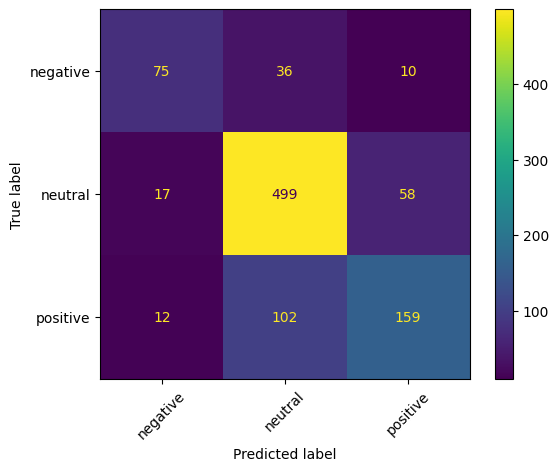

In [48]:
pipe = Pipeline([
    ("tfidf", TfidfVectorizer(strip_accents="unicode", sublinear_tf=True)),
    ("clf", LinearSVC(random_state=SEED))
])

param_grid = {
    "tfidf__ngram_range": [(1,1), (1,2), (1,3)],
    "tfidf__min_df": [1,2,3],
    "tfidf__max_df": [0.9, 0.95, 1.0],
    "clf__C": [0.25, 0.5, 1.0, 2.0]
}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
gs = GridSearchCV(pipe, param_grid, scoring="f1_macro", cv=cv, n_jobs=-1, verbose=1)
gs.fit(X_train, y_train)
print(gs.best_params_, gs.best_score_)
best = gs.best_estimator_
pred = best.predict(X_test)
print(classification_report(y_test, pred, digits=3))
ConfusionMatrixDisplay(confusion_matrix(y_test, pred, labels=best.classes_), display_labels=best.classes_).plot(xticks_rotation=45); plt.show()


(Why LinearSVC?) It’s strong on short texts with sparse TF-IDF features and handles imbalance decently (evaluate with macro-F1).

## 6) Error analysis (two cells)
Misclassified examples:

In [49]:
test_df = pd.DataFrame({"text": X_test, "true": y_test, "pred": pred})
errors = test_df[test_df.true != test_df.pred]
errors.sample(min(20, len(errors)), random_state=SEED)


,text,true,pred
2238,The sale will lead to a pretax capital gain of EUR 22 million for the Finnish company in 2011 .,positive,neutral
2777,Aldata noted that its Voice Supply Chain Technology approach enables VDW to integrate with warehouse management systems .,neutral,positive
2513,Neste Shipping is the most likely to remain Finnish as the oil sector and its transports are significant for emergency supply .,neutral,positive
1989,"Markets had been expecting a poor performance , and the company 's stock was up 6 percent at x20ac 23.89 US$ 33.84 in early afternoon trading in Helsinki .",positive,negative
4721,Export declined by 6 percent to 16.4 million liters .,negative,positive
1065,"Only this time , Nokia , India 's largest MNC , has sought out a topic that could spark off a million approaches ` Creativity in Emerging Markets .",neutral,negative
4599,Sales fell abroad but increased in Finland .,neutral,negative
708,"Due to rapid expansion , the market share of Tallink in terms of passenger carriage through Tallinna Sadam Port of Tallinn totaled 55 percent in November against 45.7 percent in November 2005 .",positive,negative
817,"According to Schmardin , Nordea will most likely try to win customers over from other pension fund providers .",positive,neutral
2152,Net profit in the same period in 2006 was 36.6 million euros .,neutral,positive


### What features drive each class (LogReg version, optional):

In [50]:
logit = Pipeline([
    ("tfidf", TfidfVectorizer(ngram_range=(1,2), min_df=2, max_df=0.95, strip_accents="unicode", sublinear_tf=True)),
    ("clf", LogisticRegression(max_iter=2000, class_weight="balanced", n_jobs=-1))
]).fit(X_train, y_train)

vec = logit.named_steps["tfidf"]
clf = logit.named_steps["clf"]
feature_names = np.array(vec.get_feature_names_out())
for i, cls in enumerate(clf.classes_):
    top = np.argsort(clf.coef_[i])[-20:][::-1]
    print(f"\nTop terms for {cls}:")
    print(feature_names[top])



Top terms for negative:
['down' 'decreased' 'fell' 'lower' 'staff' 'down from' 'result' 'off'
 'lay' 'dropped' 'decreased to' 'negative' 'had' 'fall' 'decreased by'
 'due to' 'in finland' 'half' 'to eur' 'profit']

Top terms for neutral:
['is' 'approximately' 'no' 'stake' 'includes' 'business' 'will'
 'development' 'will be' 'other' 'power' 'not' 'range' 'be' 'and'
 'include' 'value of' 'stake in' 'of the' 'million and']

Top terms for positive:
['increase' 'increased' 'rose' 'up from' 'up' 'signed' 'grew' 'rose to'
 'leading' 'positive' 'growth' 'improved' 'agreement' 'our' 'to' 'awarded'
 'to increase' 'increased by' 'mn up' 'profit rose']


Look for:

Systematic confusion (e.g., neutral vs positive for outlook-y headlines).

Phrases that should be captured by bigrams/char n-grams.

## 7) Small improvements to try (fast, classical)

Add char n-grams (good for short texts, tickers, numbers):

In [51]:
TfidfVectorizer(analyzer="char", ngram_range=(3,5), min_df=3, max_df=0.9)

,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,True
,preprocessor,None
,tokenizer,None
,analyzer,'char'
,stop_words,None
,token_pattern,'(?u)\\b\\w\\w+\\b'
,ngram_range,"(3, ...)"


Combine using FeatureUnion (optional) or just swap to char n-grams and compare.

Class weights: LinearSVC doesn’t have class_weight but LogReg does. Or downsample the majority class in train.

Stopwords: Be careful—finance words like “not”, “no”, “misses”, “beats” matter; avoid overly aggressive removal.

Domain lexicon feature (optional): Add a binary feature for words from Loughran–McDonald positive/negative/uncertainty lists and concatenate with TF-IDF.

## 8) Save model + simple inference function (two cells)

In [52]:
dump(best, "sentiment_model.joblib")


['sentiment_model.joblib']

In [53]:
model = load("sentiment_model.joblib")
def predict_sentiment(texts):
    if isinstance(texts, str):
        texts = [texts]
    return model.predict(texts)

predict_sentiment([
    "Company beats earnings expectations and raises guidance",
    "Shares fall after lawsuit concerns",
    "Board considers options amid market volatility"
])


array(['neutral', 'neutral', 'neutral'], dtype=object)

## 9) (Optional) Stronger baseline with FinBERT (very little code)

Quick zero-shot-ish pipeline (no fine-tuning). You’ll usually get a lift, especially on nuance.

In [54]:
!pip install transformers torch --upgrade


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip



  Using cached transformers-4.56.0-py3-none-any.whl.metadata (40 kB)
  Using cached torch-2.8.0-cp313-cp313-win_amd64.whl.metadata (30 kB)
  Using cached filelock-3.19.1-py3-none-any.whl.metadata (2.1 kB)
  Using cached huggingface_hub-0.34.4-py3-none-any.whl.metadata (14 kB)
  Using cached regex-2025.8.29-cp313-cp313-win_amd64.whl.metadata (41 kB)
  Using cached tokenizers-0.22.0-cp39-abi3-win_amd64.whl.metadata (6.9 kB)
  Using cached safetensors-0.6.2-cp38-abi3-win_amd64.whl.metadata (4.1 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached fsspec-2025.7.0-py3-none-any.whl.metadata (12 kB)
  Using cached sympy-1.14.0-py3-none-any.whl.metadata (12 kB)
  Using cached networkx-3.5-py3-none-any.whl.metadata (6.3 kB)
  Using cached mpmath-1.3.0-py3-none-any.whl.metadata (8.6 kB)
Using cached transformers-4.56.0-py3-none-any.whl (11.6 MB)
Using cached huggingface_hub-0.34.4-py3-none-any.whl (561 kB)
Using cached tokenizers-0.22.0-cp39-abi3-win_amd64.whl (2.7 MB

In [55]:

from transformers import AutoTokenizer, AutoModelForSequenceClassification, TextClassificationPipeline

model_name = "yiyanghkust/finbert-tone"  # or "ProsusAI/finbert"
tok = AutoTokenizer.from_pretrained(model_name)
mdl = AutoModelForSequenceClassification.from_pretrained(model_name)
pipe = TextClassificationPipeline(model=mdl, tokenizer=tok, return_all_scores=False, truncation=True)

def finbert_label_map(lbl):
    # "positive"/"negative"/"neutral" are already aligned for yiyanghkust/finbert-tone
    return lbl

preds = [finbert_label_map(pipe(t)[0]["label"]) for t in X_test.tolist()]
print(classification_report(y_test, preds, digits=3))


C:\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Python\Python313\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\shrey\.cache\huggingface\hub\models--yiyanghkust--finbert-tone. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article:

              precision    recall  f1-score   support

    Negative      0.000     0.000     0.000       0.0
     Neutral      0.000     0.000     0.000       0.0
    Positive      0.000     0.000     0.000       0.0
    negative      0.000     0.000     0.000     121.0
     neutral      0.000     0.000     0.000     574.0
    positive      0.000     0.000     0.000     273.0

    accuracy                          0.000     968.0
   macro avg      0.000     0.000     0.000     968.0
weighted avg      0.000     0.000     0.000     968.0



C:\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Python\Python313\Lib\site-packages\sklearn\metri

Fine-tuning (later): Convert labels to ids, use Trainer on your train split for a few epochs; evaluate on test.

## 10) What “good” looks like

Baseline TF-IDF + LinearSVC: macro-F1 ~0.80–0.88 is common on FPB, depending on split/variant.

FinBERT (no FT): can be competitive out of the box.

FinBERT fine-tuned on your split: often best.

## 11) Suggested notebook structure (headings)

Setup

Load Data

EDA (class balance, lengths, duplicates)

Preprocessing (minimal cleaning)

Train/Test Split

Baseline (TF-IDF → LinearSVC)

Evaluation + Confusion Matrix

Error Analysis

Iterations (char n-grams, LogReg, class weights)

FinBERT (optional +/or fine-tune later)

Save Model & Inference